In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import seaborn as sns
import pickle
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
# Load Data
data = pd.read_csv(r'C:\Users\SATHVIK\OneDrive\Desktop\smartinternz\Thyroid\Data\thyroidDF.csv')
data

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,M,f,f,f,f,f,f,f,f,...,64.0,t,0.83,t,77.0,f,NaN,SVI,-,870119022
9168,22,M,f,f,f,f,f,f,f,f,...,91.0,t,0.92,t,99.0,f,NaN,SVI,-,870119023
9169,69,M,f,f,f,f,f,f,f,f,...,113.0,t,1.27,t,89.0,f,NaN,SVI,I,870119025
9170,47,F,f,f,f,f,f,f,f,f,...,75.0,t,0.85,t,88.0,f,NaN,other,-,870119027


In [3]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


In [4]:
data.isnull().sum()

age                       0
sex                     307
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
hypopituitary             0
psych                     0
TSH_measured              0
TSH                     842
T3_measured               0
T3                     2604
TT4_measured              0
TT4                     442
T4U_measured              0
T4U                     809
FTI_measured              0
FTI                     802
TBG_measured              0
TBG                    8823
referral_source           0
target                    0
patient_id                0
dtype: int64

In [5]:
# Drop redundant attributes
data.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'referral_source', 'patient_id'], axis=1, inplace=True)

In [6]:
# Remap target values to diagnostic group
diagnoses = {
    'A': 'hyperthyroid conditions', 'B': 'hyperthyroid conditions',
    'C': 'hyperthyroid conditions', 'D': 'hyperthyroid conditions',
    'E': 'hypothyroid conditions', 'F': 'hypothyroid conditions',
    'G': 'hypothyroid conditions', 'H': 'hypothyroid conditions',
    'I': 'binding protein', 'J': 'binding protein',
    'K': 'general health', 'L': 'replacement therapy',
    'M': 'replacement therapy', 'N': 'replacement therapy',
    'O': 'antithyroid treatment', 'P': 'antithyroid treatment',
    'Q': 'antithyroid treatment', 'R': 'miscellaneous',
    'S': 'miscellaneous', 'T': 'miscellaneous'
}

In [7]:
data['target'] = data['target'].map(diagnoses)
data.dropna(subset=['target'], inplace=True)


In [8]:
# Changing age of observation with age > 100 to null
data['age'] = np.where((data.age > 100), np.nan, data.age)

In [9]:
# Split the data
x = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

In [10]:
# Replace NaNs in 'sex' with 'F'
x['sex'].replace(np.nan, 'F', inplace=True)

In [11]:
# Convert the data
x['age'] = x['age'].astype('float')
x['TSH'] = x['TSH'].astype('float')
x['T3'] = x['T3'].astype('float')
x['TT4'] = x['TT4'].astype('float')
x['T4U'] = x['T4U'].astype('float')
x['FTI'] = x['FTI'].astype('float')
x['TBG'] = x['TBG'].astype('float')

In [12]:
# Ordinal encoding for categorical features
ordinal_encoder = OrdinalEncoder(dtype='int64')
x[x.columns[1:16]] = ordinal_encoder.fit_transform(x.iloc[:, 1:16])
x.fillna(0, inplace=True)

In [13]:
# Label encoding for the target variable
label_encoder = LabelEncoder()
y = pd.DataFrame(label_encoder.fit_transform(y), columns=['target'])

In [14]:
x

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG
4,32.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000,0.0,0.0,0.00,0.0,36.0
18,63.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,68.000000,0.0,48.0,1.02,47.0,0.0
32,41.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.050000,1.6,39.0,1.00,39.0,0.0
33,71.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0.050000,0.0,126.0,1.38,91.0,0.0
39,55.0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,9.599999,2.4,136.0,1.48,92.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9153,64.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.810000,0.0,31.0,0.55,56.0,0.0
9157,60.0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0.180000,0.0,28.0,0.87,32.0,0.0
9158,64.0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0.000000,0.0,44.0,0.53,83.0,0.0
9162,36.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000,0.0,84.0,1.26,67.0,0.0


In [15]:
y

,target
0,5
1,4
2,5
3,1
4,6
...,...
2232,2
2233,2
2234,1
2235,1


<Axes: >

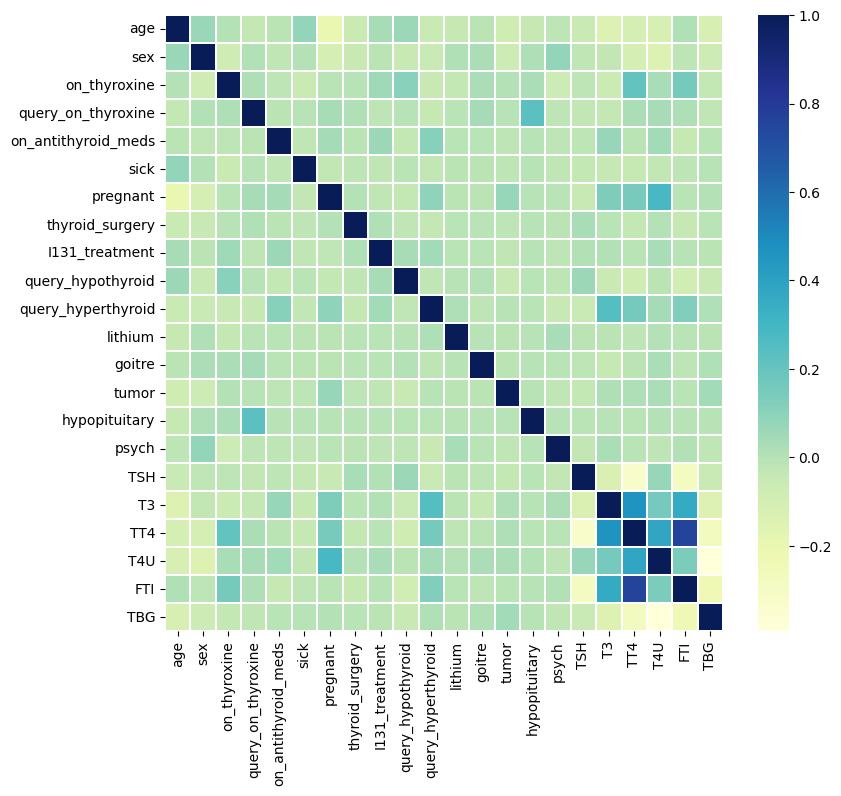

In [16]:
# checking correlation using Heatmap
import seaborn as sns
corrmat = x.corr()
f, ax = plt.subplots (figsize = (9, 8))
sns.heatmap (corrmat, ax = ax, cmap = "YlGnBu", linewidths = 0.1)

In [17]:
# Select only the important features
selected_features = ['goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
x = x[selected_features]


In [18]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

In [19]:
# Scale the data
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)


In [20]:
# Handling imbalanced data using SMOTE
os = SMOTE(random_state=0, k_neighbors=1)
x_train_bal, y_train_bal = os.fit_resample(x_train, y_train)
x_test_bal, y_test_bal = os.fit_resample(x_test, y_test)


In [21]:
# Convert arrays to dataframes
x_train_bal = pd.DataFrame(x_train_bal, columns=selected_features)
y_train_bal = pd.DataFrame(y_train_bal, columns=['target'])
x_test_bal = pd.DataFrame(x_test_bal, columns=selected_features)
y_test_bal = pd.DataFrame(y_test_bal, columns=['target'])


In [22]:
x_train_bal.shape

(3297, 10)

In [23]:
# Random Forest Classifier Model
rfr = RandomForestClassifier().fit(x_train_bal, y_train_bal.values.ravel())
y_pred = rfr.predict(x_test_bal)
print("Random Forest Classifier Report:\n", classification_report(y_test_bal, y_pred))


Random Forest Classifier Report:
               precision    recall  f1-score   support

           0       0.25      0.01      0.02       122
           1       0.83      0.93      0.88       122
           2       0.92      1.00      0.96       122
           3       0.77      0.89      0.82       122
           4       0.46      0.90      0.61       122
           5       0.81      0.72      0.76       122
           6       0.65      0.48      0.55       122

    accuracy                           0.70       854
   macro avg       0.67      0.70      0.66       854
weighted avg       0.67      0.70      0.66       854



In [24]:
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test_bal, y_pred))

Random Forest Confusion Matrix:
 [[  1   0   3   0 115   3   0]
 [  0 113   2   6   0   1   0]
 [  0   0 122   0   0   0   0]
 [  0   9   0 108   0   0   5]
 [  3   0   0   0 110   0   9]
 [  0  11   3   2   0  88  18]
 [  0   3   2  25  16  17  59]]


In [25]:
RFAcc = accuracy_score(y_test_bal, y_pred)
print('Random Forest accuracy is: {:.2f}%'.format(RFAcc * 100))

Random Forest accuracy is: 70.37%


In [27]:
print(x_train_bal.shape, y_train_bal.shape, x_test_bal.shape, y_test_bal.shape)

(3297, 10) (3297, 1) (854, 10) (854, 1)


In [28]:
from sklearn.metrics import accuracy_score
test_score=accuracy_score(y_test_bal,y_pred)

In [29]:
test_score

0.7037470725995316

In [36]:
# HyperParameter Tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10, None]
}

In [37]:
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)
grid_rf.fit(x_train_bal, y_train_bal.values.ravel())
print("Best parameters for Random Forest:", grid_rf.best_params_)
y_pred = grid_rf.predict(x_test_bal)
print("Random Forest Classifier Report after tuning:\n", classification_report(y_test_bal, y_pred))

Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 300}
Random Forest Classifier Report after tuning:
               precision    recall  f1-score   support

           0       0.40      0.02      0.03       122
           1       0.82      0.93      0.87       122
           2       0.93      0.98      0.95       122
           3       0.77      0.90      0.83       122
           4       0.46      0.89      0.60       122
           5       0.84      0.73      0.78       122
           6       0.67      0.52      0.59       122

    accuracy                           0.71       854
   macro avg       0.70      0.71      0.67       854
weighted avg       0.70      0.71      0.67       854



In [38]:
print("Random Forest Confusion Matrix after tuning:\n", confusion_matrix(y_test_bal, y_pred))

Random Forest Confusion Matrix after tuning:
 [[  2   0   2   0 114   4   0]
 [  0 113   2   6   0   1   0]
 [  0   3 119   0   0   0   0]
 [  0   8   0 110   0   0   4]
 [  3   0   0   0 109   0  10]
 [  0  11   3   1   0  89  18]
 [  0   3   2  25  16  12  64]]


In [39]:
# XGBoost Classifier Model
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_bal)
xgb = XGBClassifier()
xgb.fit(x_train_bal, y_train_encoded)
y_test_encoded = le.transform(y_test_bal)
y_pred = xgb.predict(x_test_bal)
print("XGB Classifier Report:\n", classification_report(y_test_encoded, y_pred))


XGB Classifier Report:
               precision    recall  f1-score   support

           0       0.79      0.18      0.29       122
           1       0.80      0.94      0.87       122
           2       0.97      0.98      0.97       122
           3       0.76      0.86      0.81       122
           4       0.48      0.85      0.62       122
           5       0.86      0.73      0.79       122
           6       0.68      0.57      0.62       122

    accuracy                           0.73       854
   macro avg       0.76      0.73      0.71       854
weighted avg       0.76      0.73      0.71       854



In [40]:
print("XGB Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))

XGB Confusion Matrix:
 [[ 22   0   0   0  96   4   0]
 [  0 115   0   6   0   1   0]
 [  0   3 119   0   0   0   0]
 [  0  13   0 105   0   0   4]
 [  5   0   0   0 104   0  13]
 [  1  10   2   4   0  89  16]
 [  0   2   2  23  15  10  70]]


In [41]:
XGBAcc = accuracy_score(y_test_encoded, y_pred)
print('XGB accuracy is: {:.2f}%'.format(XGBAcc * 100))

XGB accuracy is: 73.07%


In [42]:
# HyperParameter Tuning for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

In [ ]:
grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5)
grid_search.fit(x_train_bal, y_train_encoded)
print("Best parameters for XGBClassifier:", grid_search.best_params_) 
y_pred = grid_search.best_estimator_.predict(x_test_bal)
print("XGB Classifier Report after tuning:\n", classification_report(y_test_encoded, y_pred))

In [ ]:
print("XGB Confusion Matrix after tuning:\n", confusion_matrix(y_test_encoded, y_pred))

In [ ]:
# SVC Model
svc = SVC(kernel='linear', max_iter=251)
svc.fit(x_train_bal, y_train_bal.values.ravel())
y_pred = svc.predict(x_test_bal)
print("SVC Report:\n", classification_report(y_test_bal, y_pred))

In [ ]:
print("SVC Confusion Matrix:\n", confusion_matrix(y_test_bal, y_pred))

In [ ]:
SVCAcc = accuracy_score(y_test_bal, y_pred)
print('SVC accuracy is: {:.2f}%'.format(SVCAcc * 100))

In [ ]:
# HyperParameter Tuning for SVC
svc_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto']
}

In [ ]:
grid_svc = GridSearchCV(SVC(), svc_params, cv=5)
grid_svc.fit(x_train_bal, y_train_bal.values.ravel())
print("Best parameters for SVC:", grid_svc.best_params_)
y_pred = grid_svc.best_estimator_.predict(x_test_bal)
print("SVC Report after tuning:\n", classification_report(y_test_bal, y_pred))
print("SVC Confusion Matrix after tuning:\n", confusion_matrix(y_test_bal, y_pred))

In [ ]:
# Compare models
models = pd.DataFrame({
    'Model': ['Random Forest Classifier', 'SVC Model', 'XGB classifier'],
    'Score': [RFAcc, SVCAcc, XGBAcc]
})

In [ ]:
models.sort_values(by='Score', ascending=False)

In [ ]:
# Save the best model
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)